# Clock Protein Data Exploration


In [1]:
###############################################################################
#
#   get all pairwise PPI scores for the AF and RF datasets
#   
#   creates `clock_RF_scores.csv` from `RF_scores` and
#               `clock_AF_scores.csv` from `AF_scores`
#
###############################################################################

import pandas as pd

# Load data mapping gene names to UniProt codes
clock_genes_uniprot_df = pd.read_csv("./data/clock_uniprot_codes.csv")
hallmark_genes_uniprot_df = pd.read_csv("./data/hallmark_uniprot_codes.csv")

# Extract UniProt codes
clock_codes = clock_genes_uniprot_df["uniprot_code"]
hallmark_codes = hallmark_genes_uniprot_df["uniprot_code"]

# Generate all combinations of clock-clock and clock-hallmark pairs
def create_pairs(first_codes, second_codes):
    return [f"{first}_{second}" for first in first_codes for second in second_codes]

# Clock gene pairs (clock-clock)
clock_pairs = create_pairs(clock_codes, clock_codes)

# Clock-hallmark gene pairs (clock-hallmark, hallmark-clock)
clock_hallmark_pairs = create_pairs(clock_codes, hallmark_codes) +  \
                        create_pairs(hallmark_codes, clock_codes) + \
                        clock_pairs
print("clock pairs:")
print(clock_pairs)

print("\nclock-hallmark pairs:")
print(clock_hallmark_pairs)

# Load RF and AF scores data (tab-separated)
RF_scores_df = pd.read_csv("./data/RF_scores", sep='\t', header=None)
AF_scores_df = pd.read_csv("./data/AF_scores", sep='\t', header=None)

# Helper function to process and save pairwise scores
def process_and_save_scores(df, pairs, filename):
    # Filter rows where gene pairs match the provided pairs
    filtered_df = df[df[0].isin(pairs)]
    # Assign column names
    filtered_df.columns = ["gene_pairs", "score"]
    # Sort by gene pairs
    sorted_df = filtered_df.sort_values(by="gene_pairs")
    # Save to CSV
    sorted_df.to_csv(filename, index=False)

# Process and save RF scores for clock-clock and clock-hallmark pairs
process_and_save_scores(RF_scores_df, clock_pairs, './output/clock_RF_scores.csv')
process_and_save_scores(RF_scores_df, clock_hallmark_pairs, './output/clock_hallmark_RF_scores.csv')

# Process and save AF scores for clock-clock and clock-hallmark pairs
process_and_save_scores(AF_scores_df, clock_pairs, './output/clock_AF_scores.csv')
process_and_save_scores(AF_scores_df, clock_hallmark_pairs, './output/clock_hallmark_AF_scores.csv')


{'PER1': 'O15534', 'PER2': 'O15055', 'PER3': 'P56645', 'RORA': 'P35398', 'RORB': 'Q92753', 'RORC': 'P51449', 'CRY1': 'Q16526', 'CRY2': 'Q49AN0', 'NR1D1': 'P20393', 'NR1D2': 'Q14995', 'CLOCK': 'O15516', 'NPAS2': 'Q99743', 'ARNTL': 'O00327', 'ARNTL2': 'Q8WYA1'}
{'CREBBP': 'Q92793', 'EP300': 'Q09472', 'EPAS1': 'Q99814', 'MAX': 'P61244', 'RHOA': 'P61586', 'TBL1XR1': 'Q9BZK7', 'RABEP1': 'Q15276', 'SDHA': 'P31040', 'CBLB': 'Q13191', 'JAK3': 'P52333', 'NPM1': 'P06748', 'PER1': 'O15534', 'PPP2R1A': 'P30153', 'SFPQ': 'P23246', 'XPO1': 'O14980', 'ATP1A1': 'P05023', 'BRCA1': 'P38398', 'DDX3X': 'O00571', 'DICER1': 'Q9UPY3', 'EZH2': 'Q15910', 'FBXW7': 'Q969H0', 'LMNA': 'P02545', 'NONO': 'Q15233', 'RANBP2': 'P49792', 'UBR5': 'O95071', 'NCOR1': 'O75376', 'NCOR2': 'Q9Y618', 'CLTC': 'Q00610', 'EIF3E': 'P60228', 'EZR': 'P15311', 'HNRNPA2B1': 'P22626', 'MLH1': 'P40692', 'TP53': 'Q12888', 'ATM': 'Q13315', 'CHEK2': 'O96017', 'HIF1A': 'Q16665', 'MYOD1': 'P15172', 'STAG2': 'Q8N3U4', 'LCK': 'P06239'}


NameError: name 'clock_codes' is not defined

In [8]:
###############################################################################
#
#   create pairwise tables for all gene pairs
#
#   uses `clock_RF_scores.csv` to create `clock_RF_score_matrix_unsorted.csv`
#   and `clock_RF_score_matrix_sorted.csv`, and `clock_AF_scores.csv` to create
#   `clock_AF_score_matrix_unsorted.csv` and `clock_AF_score_matrix_sorted.csv`
#
###############################################################################

import pandas as pd

# Load and concatenate clock and hallmark gene UniProt data
clock_genes_uniprot_df = pd.read_csv("./data/clock_uniprot_codes.csv")
hallmark_genes_uniprot_df = pd.read_csv("./data/hallmark_uniprot_codes.csv")
genes_uniprot_df = pd.concat([clock_genes_uniprot_df, hallmark_genes_uniprot_df])

# Create a dictionary mapping UniProt codes to gene names
genes_uniprot_map = dict(zip(genes_uniprot_df["uniprot_code"], genes_uniprot_df["gene_name"]))

# Function to split gene pairs, pivot scores into a matrix, and save to CSV
def create_score_matrix(scores_df, output_file_unsorted, output_file_sorted):
    # Split gene pairs into separate columns
    scores_df[['gene_1', 'gene_2']] = scores_df['gene_pairs'].str.split('_', expand=True)
    
    # Create a pivot table to convert long-form data into a matrix
    score_matrix_df = pd.pivot_table(scores_df, values="score", index="gene_1", columns="gene_2")
    
    # Rename rows and columns using UniProt gene names
    score_matrix_df.rename(index=genes_uniprot_map, columns=genes_uniprot_map, inplace=True)
    score_matrix_df.index.name = None
    score_matrix_df.columns.name = None
    
    # Save the unsorted matrix
    score_matrix_df.to_csv(output_file_unsorted, index=True, index_label=None)
    
    # Sort the matrix by gene names and save the sorted matrix
    sorted_matrix_df = score_matrix_df.sort_index(axis=0).sort_index(axis=1)
    sorted_matrix_df.to_csv(output_file_sorted, index=True, index_label=None)

# Process RF and AF score matrices for clock-clock and clock-hallmark pairs
def process_scores(input_file, output_file_unsorted, output_file_sorted):
    scores_df = pd.read_csv(input_file)
    create_score_matrix(scores_df, output_file_unsorted, output_file_sorted)

# Process RF scores for clock-clock and clock-hallmark pairs
process_scores("./output/clock_RF_scores.csv", './output/clock_RF_score_matrix_unsorted.csv', \
                './output/clock_RF_score_matrix_sorted.csv')
process_scores("./output/clock_hallmark_RF_scores.csv", \
                './output/clock_hallmark_RF_score_matrix_unsorted.csv',  \
                './output/clock_hallmark_RF_score_matrix_sorted.csv')

# Process AF scores for clock-clock and clock-hallmark pairs
process_scores("./output/clock_AF_scores.csv", './output/clock_AF_score_matrix_unsorted.csv', \
                './output/clock_AF_score_matrix_sorted.csv')
process_scores("./output/clock_hallmark_AF_scores.csv", \
                './output/clock_hallmark_AF_score_matrix_unsorted.csv', \
                './output/clock_hallmark_AF_score_matrix_sorted.csv')


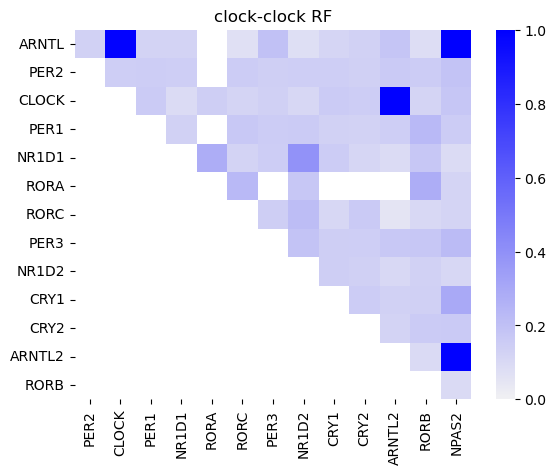

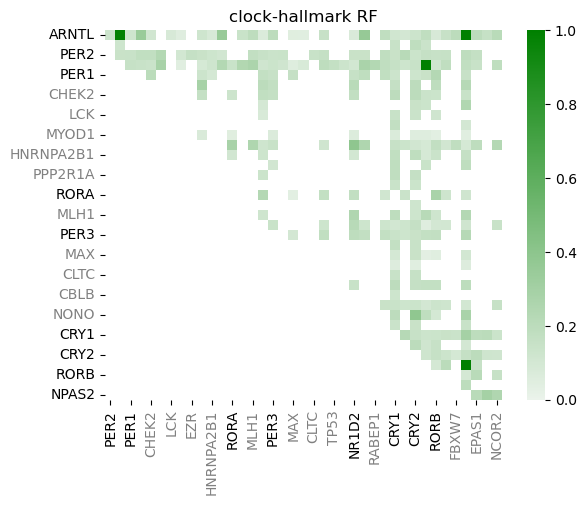

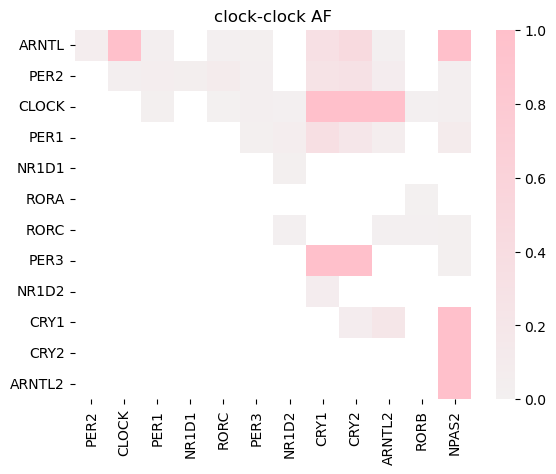

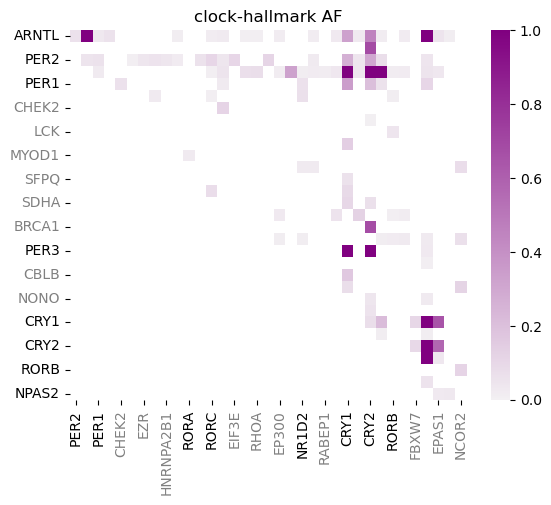

In [1]:
###############################################################################
#
#   generate clock-clock and clock-hallmark heatmap
#
###############################################################################

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Function to generate a color palette for the heatmap
def palette(color="seagreen"):
    return sns.light_palette(color, as_cmap=True)

# Load clock gene names from UniProt data
clock_genes = list(pd.read_csv("./data/clock_uniprot_codes.csv")["gene_name"])

# Function to create a heatmap and save the image
def create_heatmap(df, title, output_file, color, clock_genes):
    # Generate the heatmap with the specified color palette
    heatmap = sns.heatmap(df, cmap=palette(color), vmin=0, vmax=1)
    heatmap.set_title(title)

    # Change tick label color to grey for non-clock genes
    for tick_label in heatmap.get_yticklabels():
        if tick_label.get_text() not in clock_genes:
            tick_label.set_color("grey")
    for tick_label in heatmap.get_xticklabels():
        if tick_label.get_text() not in clock_genes:
            tick_label.set_color("grey")

    # Display the heatmap
    plt.show()

    # Save the heatmap as a PNG image
    fig = heatmap.get_figure()
    fig.savefig(output_file)

# Load data and generate heatmaps for RF and AF scores
def process_heatmaps(score_matrix_file, title, output_file, color, clock_genes):
    # Load the unsorted score matrix as a DataFrame
    df = pd.read_csv(score_matrix_file, index_col=0)
    create_heatmap(df, title, output_file, color, clock_genes)

# Process heatmaps for RF scores
process_heatmaps("./output/clock_RF_score_matrix_unsorted.csv", \
                    "clock-clock RF", "./output/clock-RF-score-heatmap.png", \
                    "blue", clock_genes)
process_heatmaps("./output/clock_hallmark_RF_score_matrix_unsorted.csv", \
                    "clock-hallmark RF", \
                    "./output/clock-hallmark-RF-score-heatmap.png", \
                    "green", clock_genes)

# Process heatmaps for AF scores
process_heatmaps("./output/clock_AF_score_matrix_unsorted.csv", \
                    "clock-clock AF", "./output/clock-AF-score-heatmap.png", \
                    "pink", clock_genes)
process_heatmaps("./output/clock_hallmark_AF_score_matrix_unsorted.csv", \
                    "clock-hallmark AF", \
                    "./output/clock-hallmark-AF-score-heatmap.png",\
                    "purple", clock_genes)
